In [55]:
import numpy as np
import torch
from torch import nn
from torch import distributions
from torch.nn.parameter import Parameter
from torch.autograd import Variable
import ot # optimal transport solver
from data import *
from helpers import *
from fit import *
from model import *
from torchsummary import summary
import matplotlib
from matplotlib import pyplot as plt
matplotlib.use('nbagg')
from mpl_toolkits.mplot3d import axes3d
dtype = torch.float
device = torch.device('cpu')

# Create data points, e.g. noisy points on a 2-d plane living in 3-d

Here $y_i = x_i + \eta_i$ for $i = 1,\dots,n$ where $x_i$ live on our 2-D manifold and $\eta_i$ denotes the noise in our measurements.

In [2]:
num_points = 40
noise_var = 0.05
X, noise = sample_plane(num_points, noise_var)
X = X.float()
Y = X + noise.float()
noise_level = (noise**2).sum().sum()

# Build two feedforward ReLU nets

The networks $f(\cdot;\theta_1)$ and $f(\cdot; \theta_2)$ have two hidden layers with ReLU activation functions. For simplicity, we fit the outputs of both networks to the entire manifold.

In [3]:
D_in = 2
D_out = 3
hidden1 = 200
hidden2 = 400

# net 1
v1 = build_input(num_points, D_in)
model1 = build_network(D_in, D_out, hidden1, hidden2)

# net 2
v2 = build_input(num_points, D_in)
model2 = build_network(D_in, D_out, hidden1, hidden2)

print(model1)
print(model2)

Sequential(
  (0): Linear(in_features=2, out_features=200, bias=True)
  (1): ReLU()
  (2): Linear(in_features=200, out_features=400, bias=True)
  (3): ReLU()
  (4): Linear(in_features=400, out_features=3, bias=True)
)
Sequential(
  (0): Linear(in_features=2, out_features=200, bias=True)
  (1): ReLU()
  (2): Linear(in_features=200, out_features=400, bias=True)
  (3): ReLU()
  (4): Linear(in_features=400, out_features=3, bias=True)
)


# 1) Fit local patches individually

In order to fit each network to our 2-D manifold, we must solve the following optimization problem: 
$$\min_{\theta_1, \theta_2} \min_{\pi_1, \pi_2} \sum_{i=1}^n \left\| f(v^1_{i};\theta_1) - y_{\pi_1(i)}\right\|^2 + \left\| f(v^2_i; \theta_2) - y_{\pi_2(i)}\right\|^2.$$

## 1a) Get Permutation matrices

We find the individual permutations by solving either the EMD problem or the Sinkhorn regularized version. Here we solve the EMD problem directly.

In [4]:
# Get pairwise distance matrices
Y1_pred = model1(v1) # initial network predictions
Y2_pred = model2(v2)
C1 = pairwise_distance_matrix(Y1_pred, Y).double()
C2 = pairwise_distance_matrix(Y2_pred, Y).double() 
C1_np = C1.clone().detach().numpy()
C2_np = C2.clone().detach().numpy()

# Find permutation matrices using EMD or sinkhorn
lam = 0.01
a, b = np.ones((num_points,)), np.ones((num_points,))
P1_np = get_permutation_matrix(a, b, C1_np, 100000, lam, 'EMD')
P2_np = get_permutation_matrix(a, b, C2_np, 100000, lam, 'EMD')
P1 = Variable(torch.from_numpy(P1_np), requires_grad=False)
P2 = Variable(torch.from_numpy(P2_np), requires_grad=False)

## 1b) Fit each network to the patch

Here training loss is the MSE with respect to noisy points and test loss is the MSE with respect to clean points.

In [5]:
loss_fn = torch.nn.MSELoss(reduction = "sum")
maxiter = 6000
lr = 1e-4
error_train_net1, error_test_net1, error_train_net2, error_test_net2 = fit_local_patch(v1, model1,
                                                                                      v2, model2,
                                                                                      loss_fn,
                                                                                      maxiter,
                                                                                      noise_level,
                                                                                      lr,
                                                                                      P1,
                                                                                      P2,
                                                                                      Y,
                                                                                      X)

Fitting of local patches...
Iteration:0, Training loss (net 1):99.03827108442783, Test loss (net 1):98.5681736767292
Iteration:0, Training loss (net 2):103.79693706333637, Test loss (net 2):103.37999099493027
Noise level:0.34979533997647894
Iteration:1000, Training loss (net 1):1.2011593356728554, Test loss (net 1):1.2728957757353783
Iteration:1000, Training loss (net 2):0.8952953405678272, Test loss (net 2):1.1451517082750797
Noise level:0.34979533997647894
Iteration:2000, Training loss (net 1):0.1624411717057228, Test loss (net 1):0.4941551983356476
Iteration:2000, Training loss (net 2):0.3026561923325062, Test loss (net 2):0.6017833165824413
Noise level:0.34979533997647894
Iteration:3000, Training loss (net 1):0.029373612254858017, Test loss (net 1):0.38533227518200874
Iteration:3000, Training loss (net 2):0.13592985272407532, Test loss (net 2):0.47373758628964424
Noise level:0.34979533997647894
Iteration:4000, Training loss (net 1):0.004056364297866821, Test loss (net 1):0.35435489

# Plot training and test loss during local fitting
Here we see that the networks individually fit well to the patch

<IPython.core.display.Javascript object>


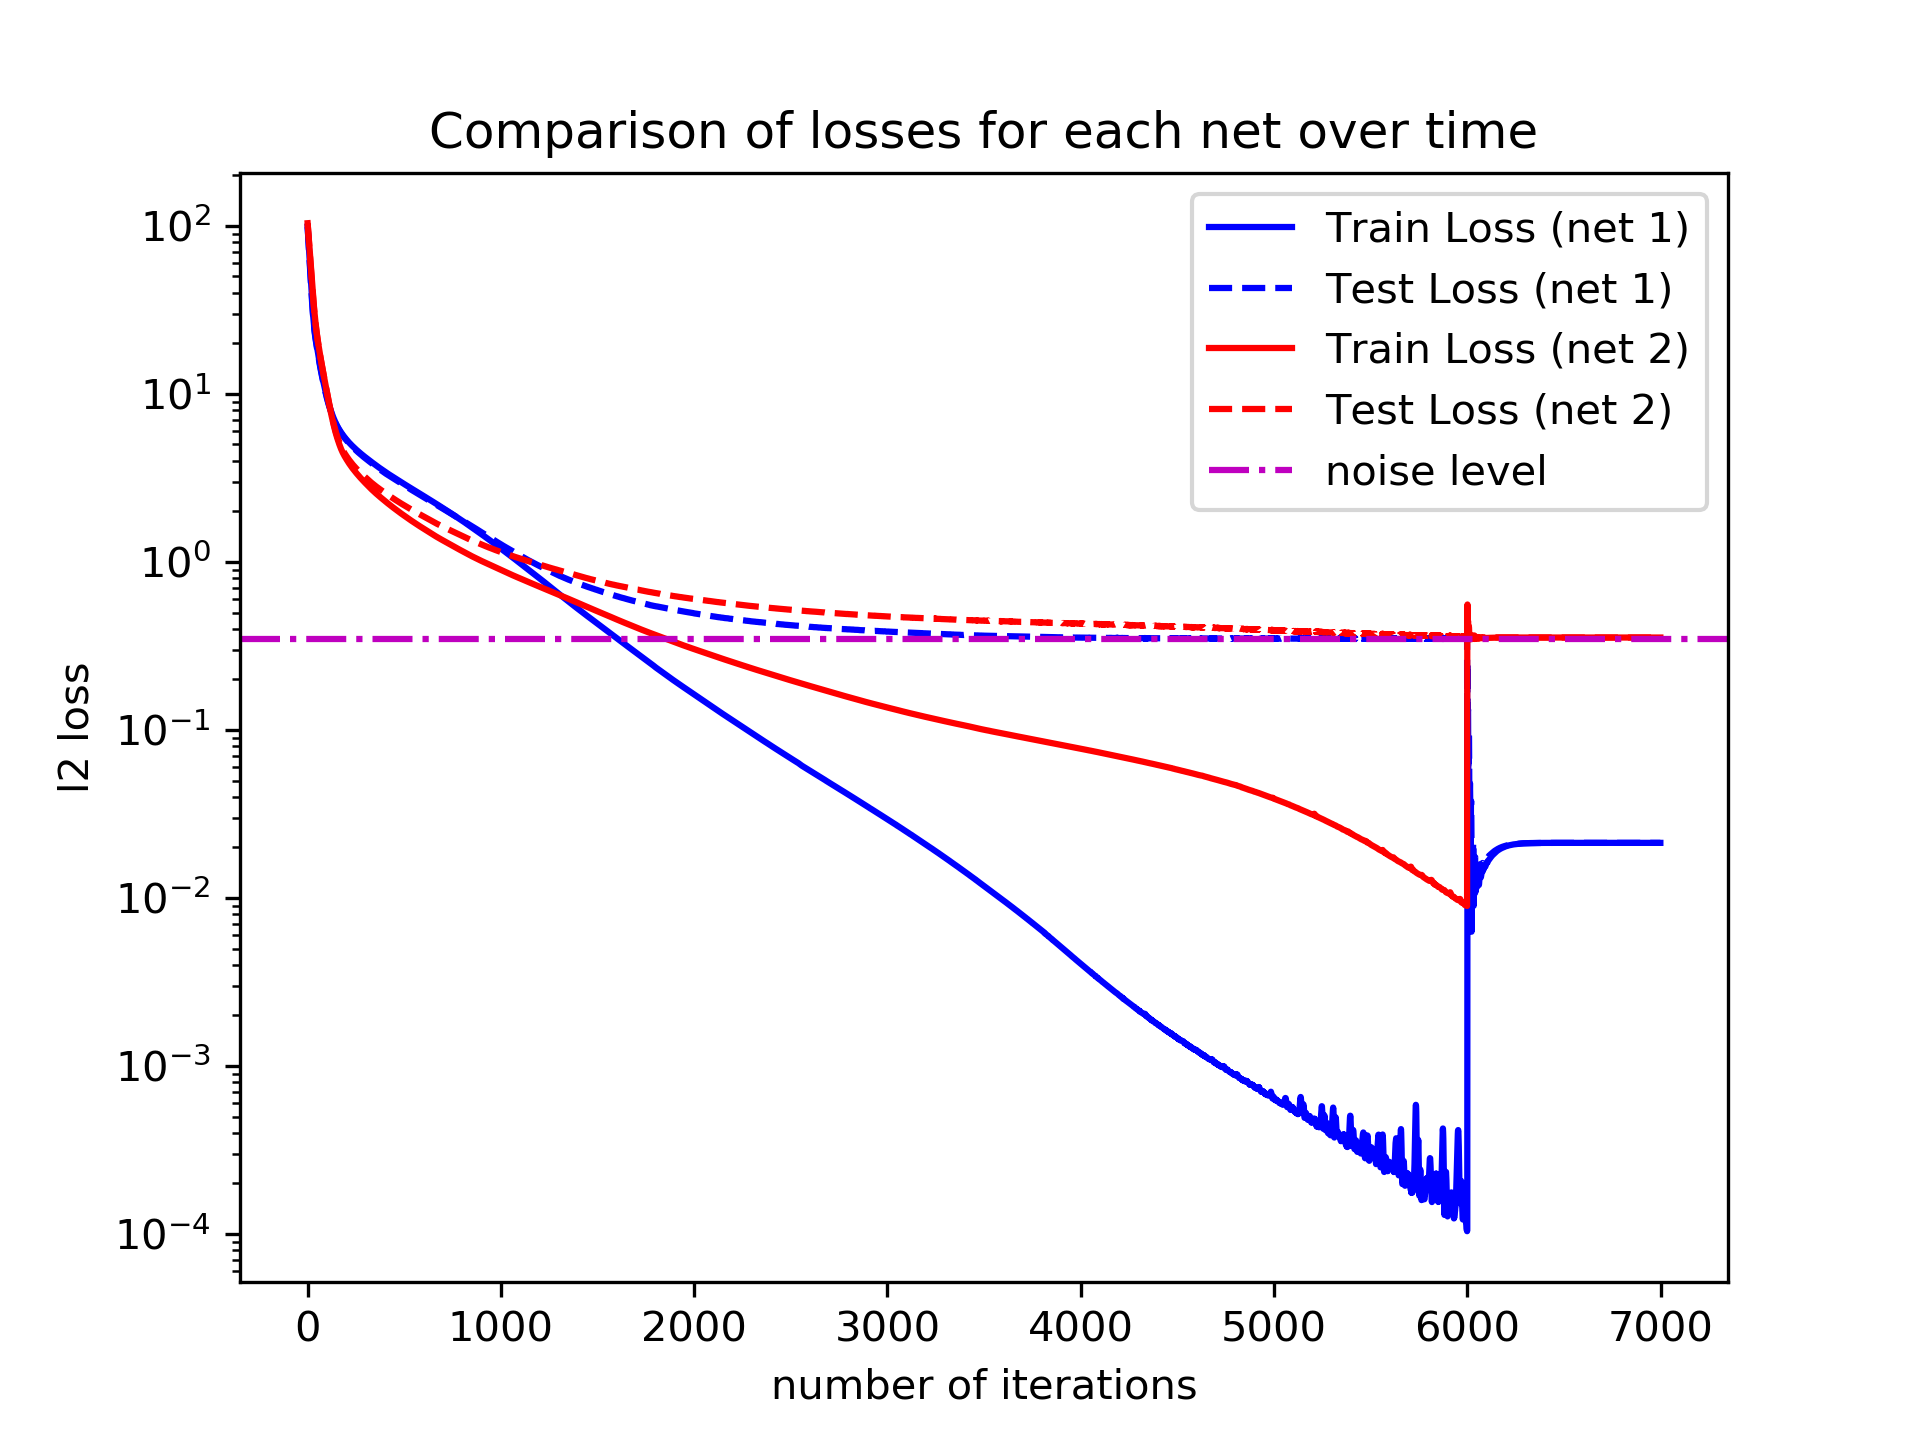

In [56]:
# Plot all losses(training and test)
plt.figure()
plt.plot(error_train_net1, color='b', linestyle='-', label='Train Loss (net 1)')
plt.plot(error_test_net1, color='b', linestyle='--', label='Test Loss (net 1)')
plt.plot(error_train_net2, color='r', linestyle='-', label='Train Loss (net 2)')
plt.plot(error_test_net2, color='r', linestyle='--',  label='Test Loss (net 2)')
plt.axhline(y=noise_level, color='m', linestyle='-.', label='noise level')
plt.ylabel('l2 loss')
plt.xlabel('number of iterations')
plt.yscale('log')
plt.title('Comparison of losses for each net over time')
plt.legend()

# 2) Fit networks to one another
## 2a) Get mapping from parametric indices

In [7]:
# Get permutation pi_p->q between parametric indices P1hat, P2hat_inv
P1_npinv = np.linalg.inv(P1_np)
P2_npinv = np.linalg.inv(P2_np)
P3 = get_permutation_btwn_parametric(P1_np, P2_npinv)

## 2b) Ensure network outputs are consistent with one another

In [8]:
const_train_net1, const_test_net1, const_train_net2, const_test_net2 = fit_consistency(v1, model1,
                                                                                       v2, model2,
                                                                                       1000,
                                                                                       noise_level,
                                                                                       lr,
                                                                                       P1,
                                                                                       P2,
                                                                                       P3,
                                                                                       Y,
                                                                                       X)

# Compile errors
error_train_net1 += const_train_net1
error_train_net2 += const_train_net2
error_test_net1 += const_test_net1
error_test_net2 += const_test_net2

Consistency fitting...
Iteration:0, Training loss (net 1):0.00010702386498451233, Test loss (net 1):0.34905054047703743
Iteration:0, Training loss (net 2):0.008941326290369034, Test loss (net 2):0.3605935648083687
Iteration:0, Consistency loss:0.009118881076574326
Noise level:0.34979533997647894
Iteration:500, Training loss (net 1):0.021271508187055588, Test loss (net 1):0.35483986139297485
Iteration:500, Training loss (net 2):0.021266795694828033, Test loss (net 2):0.3548363335430622
Iteration:500, Consistency loss:-1.1548399925231934e-07
Noise level:0.34979533997647894
--------------------------------------------------------------


# Compare training and test loss for each network
Appending the loss values from the consistency fitting, we see two things:
1. Test losses stay near noise level
2. Training losses worsen

<IPython.core.display.Javascript object>


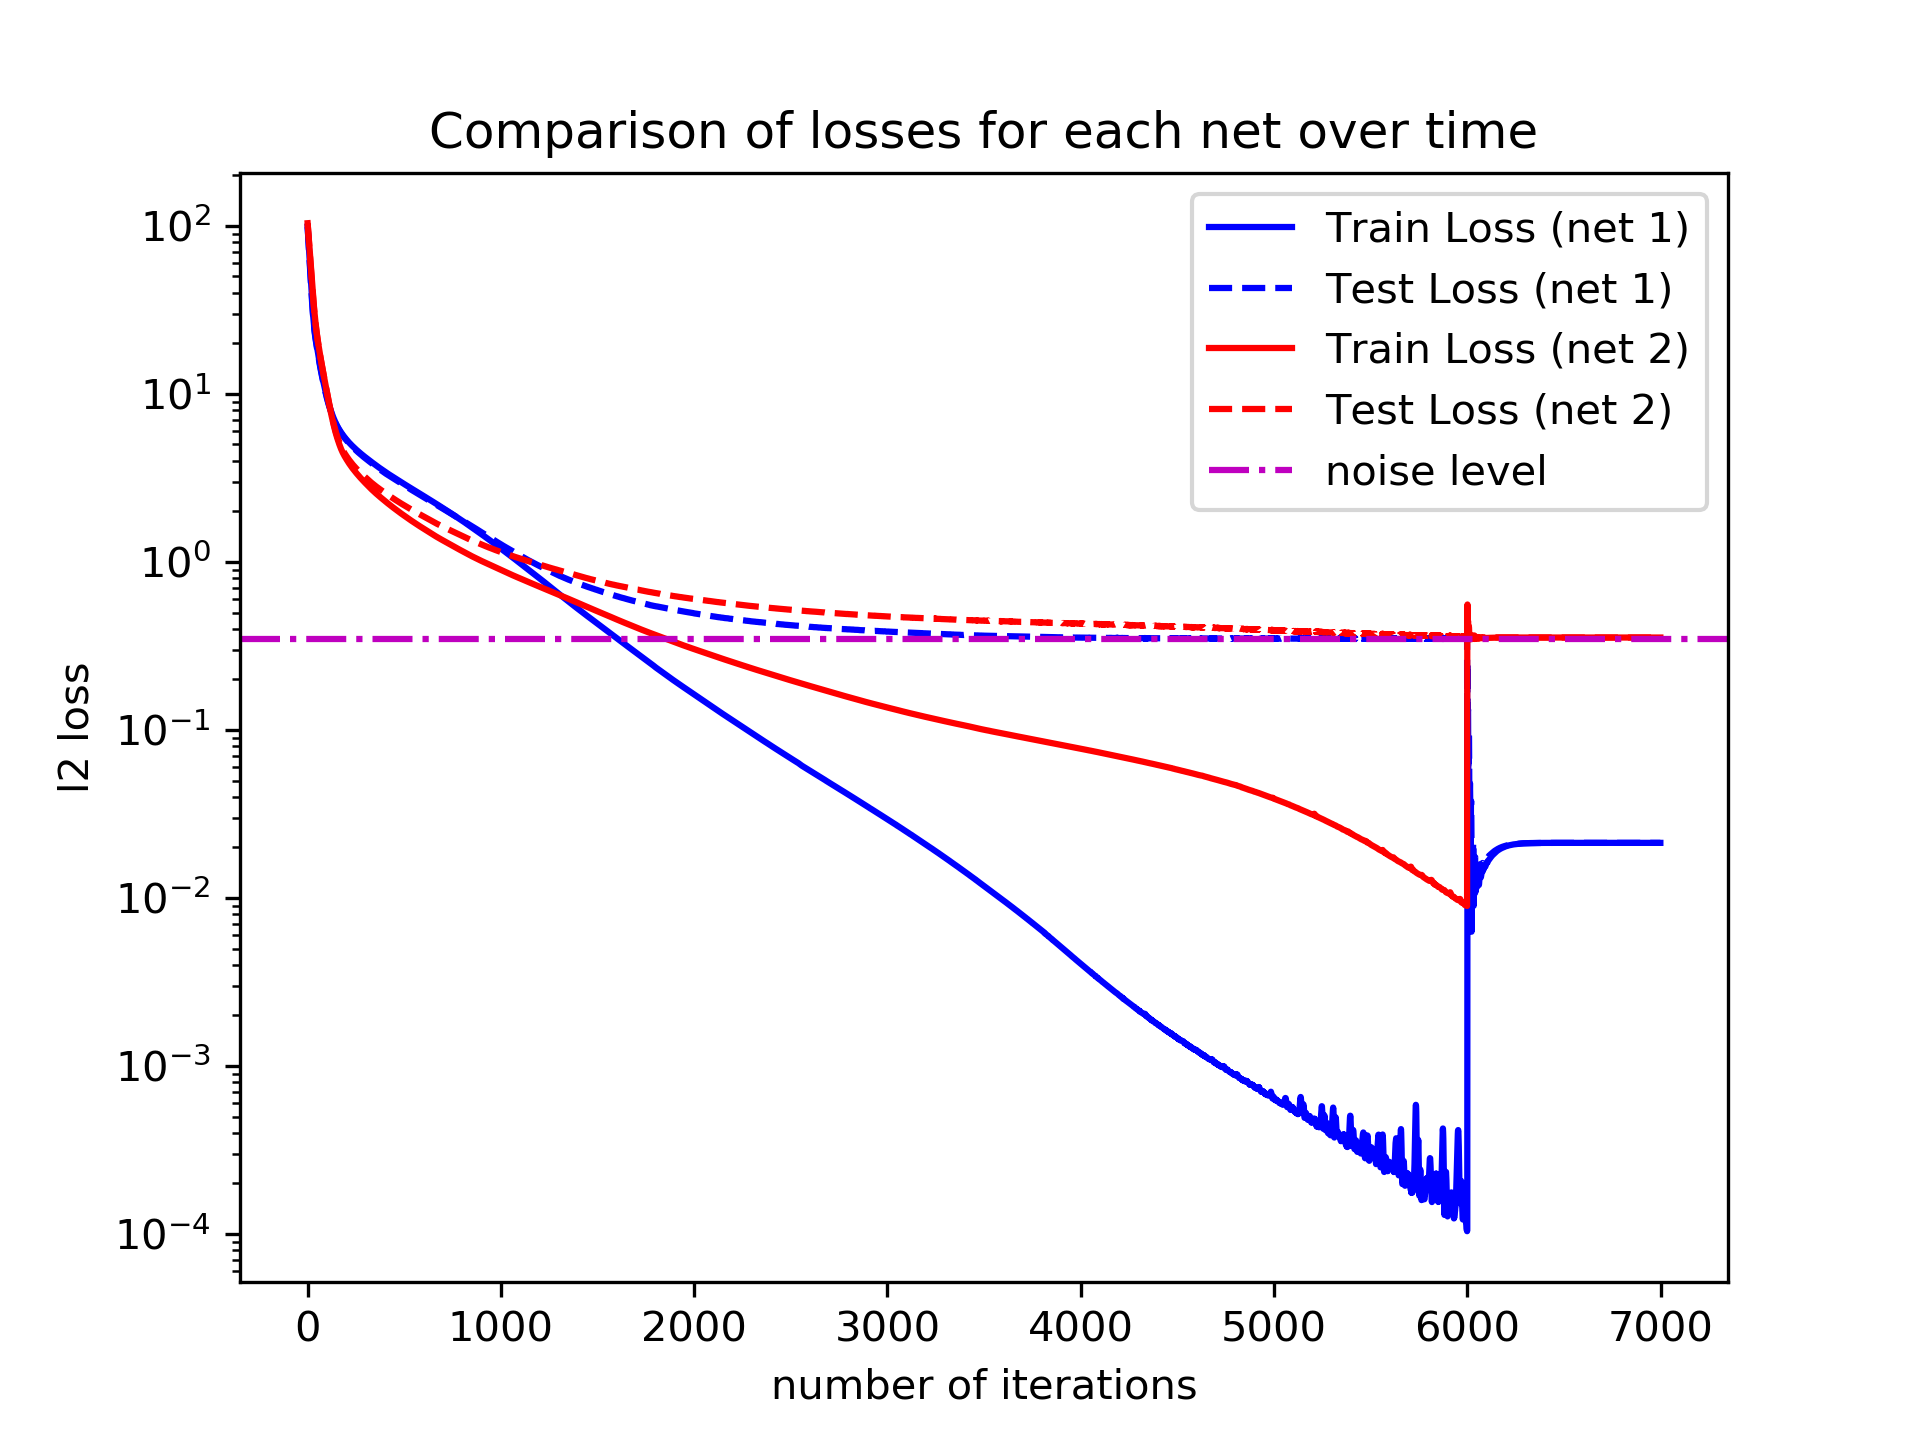

In [57]:
# Plot all losses(training and test)
plt.figure()
plt.plot(error_train_net1, color='b', linestyle='-', label='Train Loss (net 1)')
plt.plot(error_test_net1, color='b', linestyle='--', label='Test Loss (net 1)')
plt.plot(error_train_net2, color='r', linestyle='-', label='Train Loss (net 2)')
plt.plot(error_test_net2, color='r', linestyle='--',  label='Test Loss (net 2)')
plt.axhline(y=noise_level, color='m', linestyle='-.', label='noise level')
plt.ylabel('l2 loss')
plt.xlabel('number of iterations')
plt.yscale('log')
plt.title('Comparison of losses for each net over time')
plt.legend()

# Plot noisy and clean data points

Plotting noisy and clean points along with the plane the clean data points lie on.

<IPython.core.display.Javascript object>


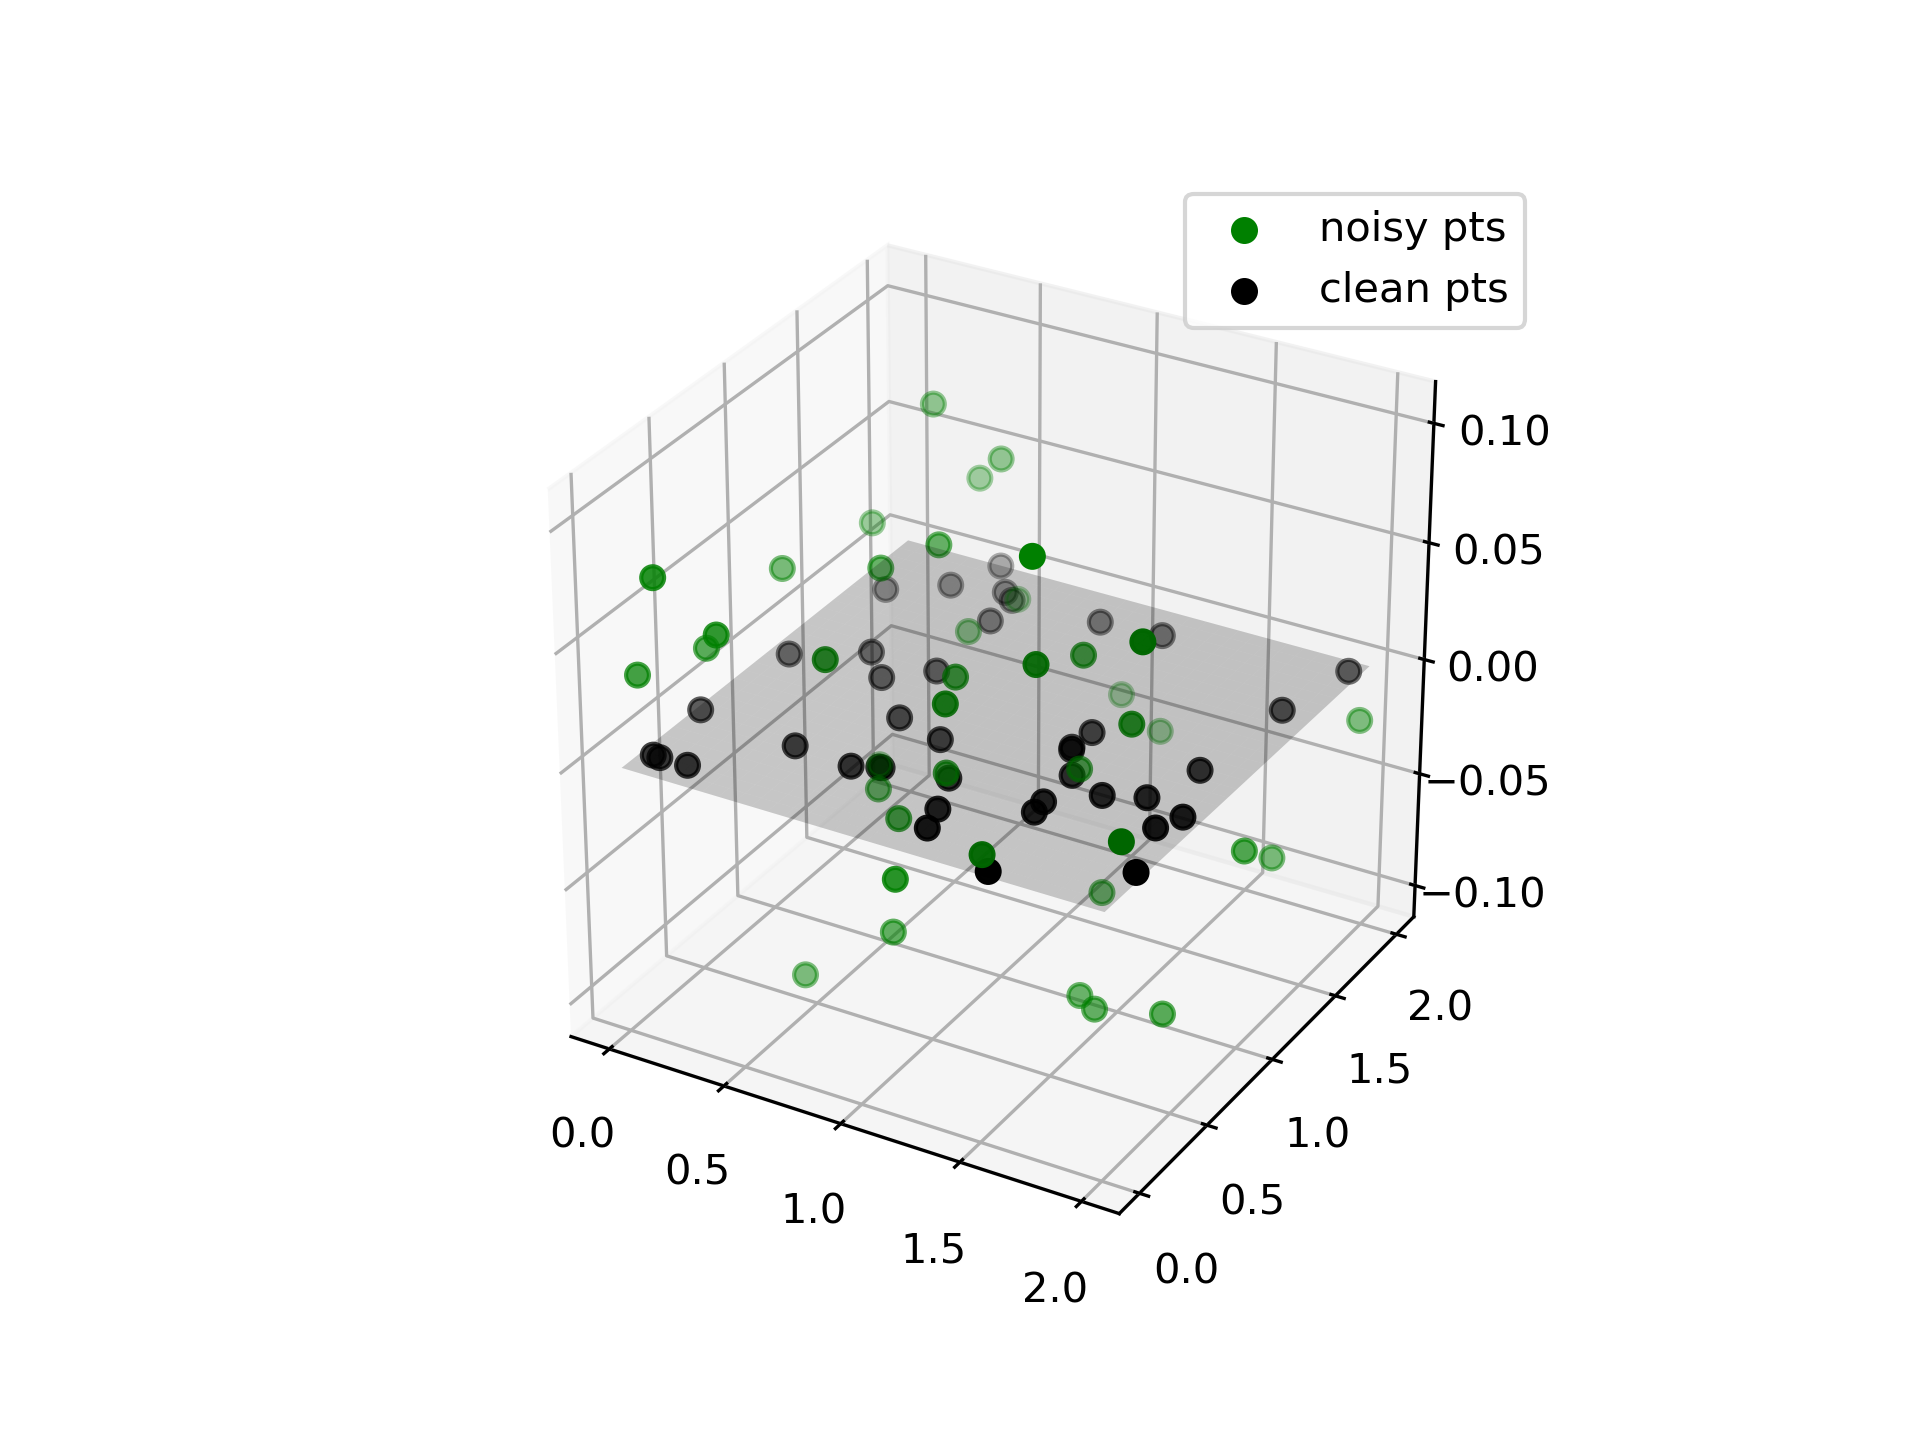

In [58]:
planeX, planeY = np.meshgrid(np.linspace(0,2,30), np.linspace(0,2,30))
planeZ = np.zeros((30,30))
fig, ax = plt.subplots(1, 1, subplot_kw={'projection':'3d', 'aspect':'equal'})
ax.scatter(Y[:100,0], Y[:100,1], Y[:100,2], s = 30, c = 'g', zorder = 10, label = 'noisy pts')
ax.scatter(X[:100,0], X[:100,1], X[:100,2], s = 30, c = 'k', zorder = 10, label = 'clean pts')
ax.plot_surface(planeX, planeY, planeZ, rstride=1, cstride=1, alpha=0.2,
                cmap='bone', edgecolor='none')
ax.legend()

# Plot reconstructed points along with data points

We see that the recovered points are much closer to the noisy points.

<IPython.core.display.Javascript object>


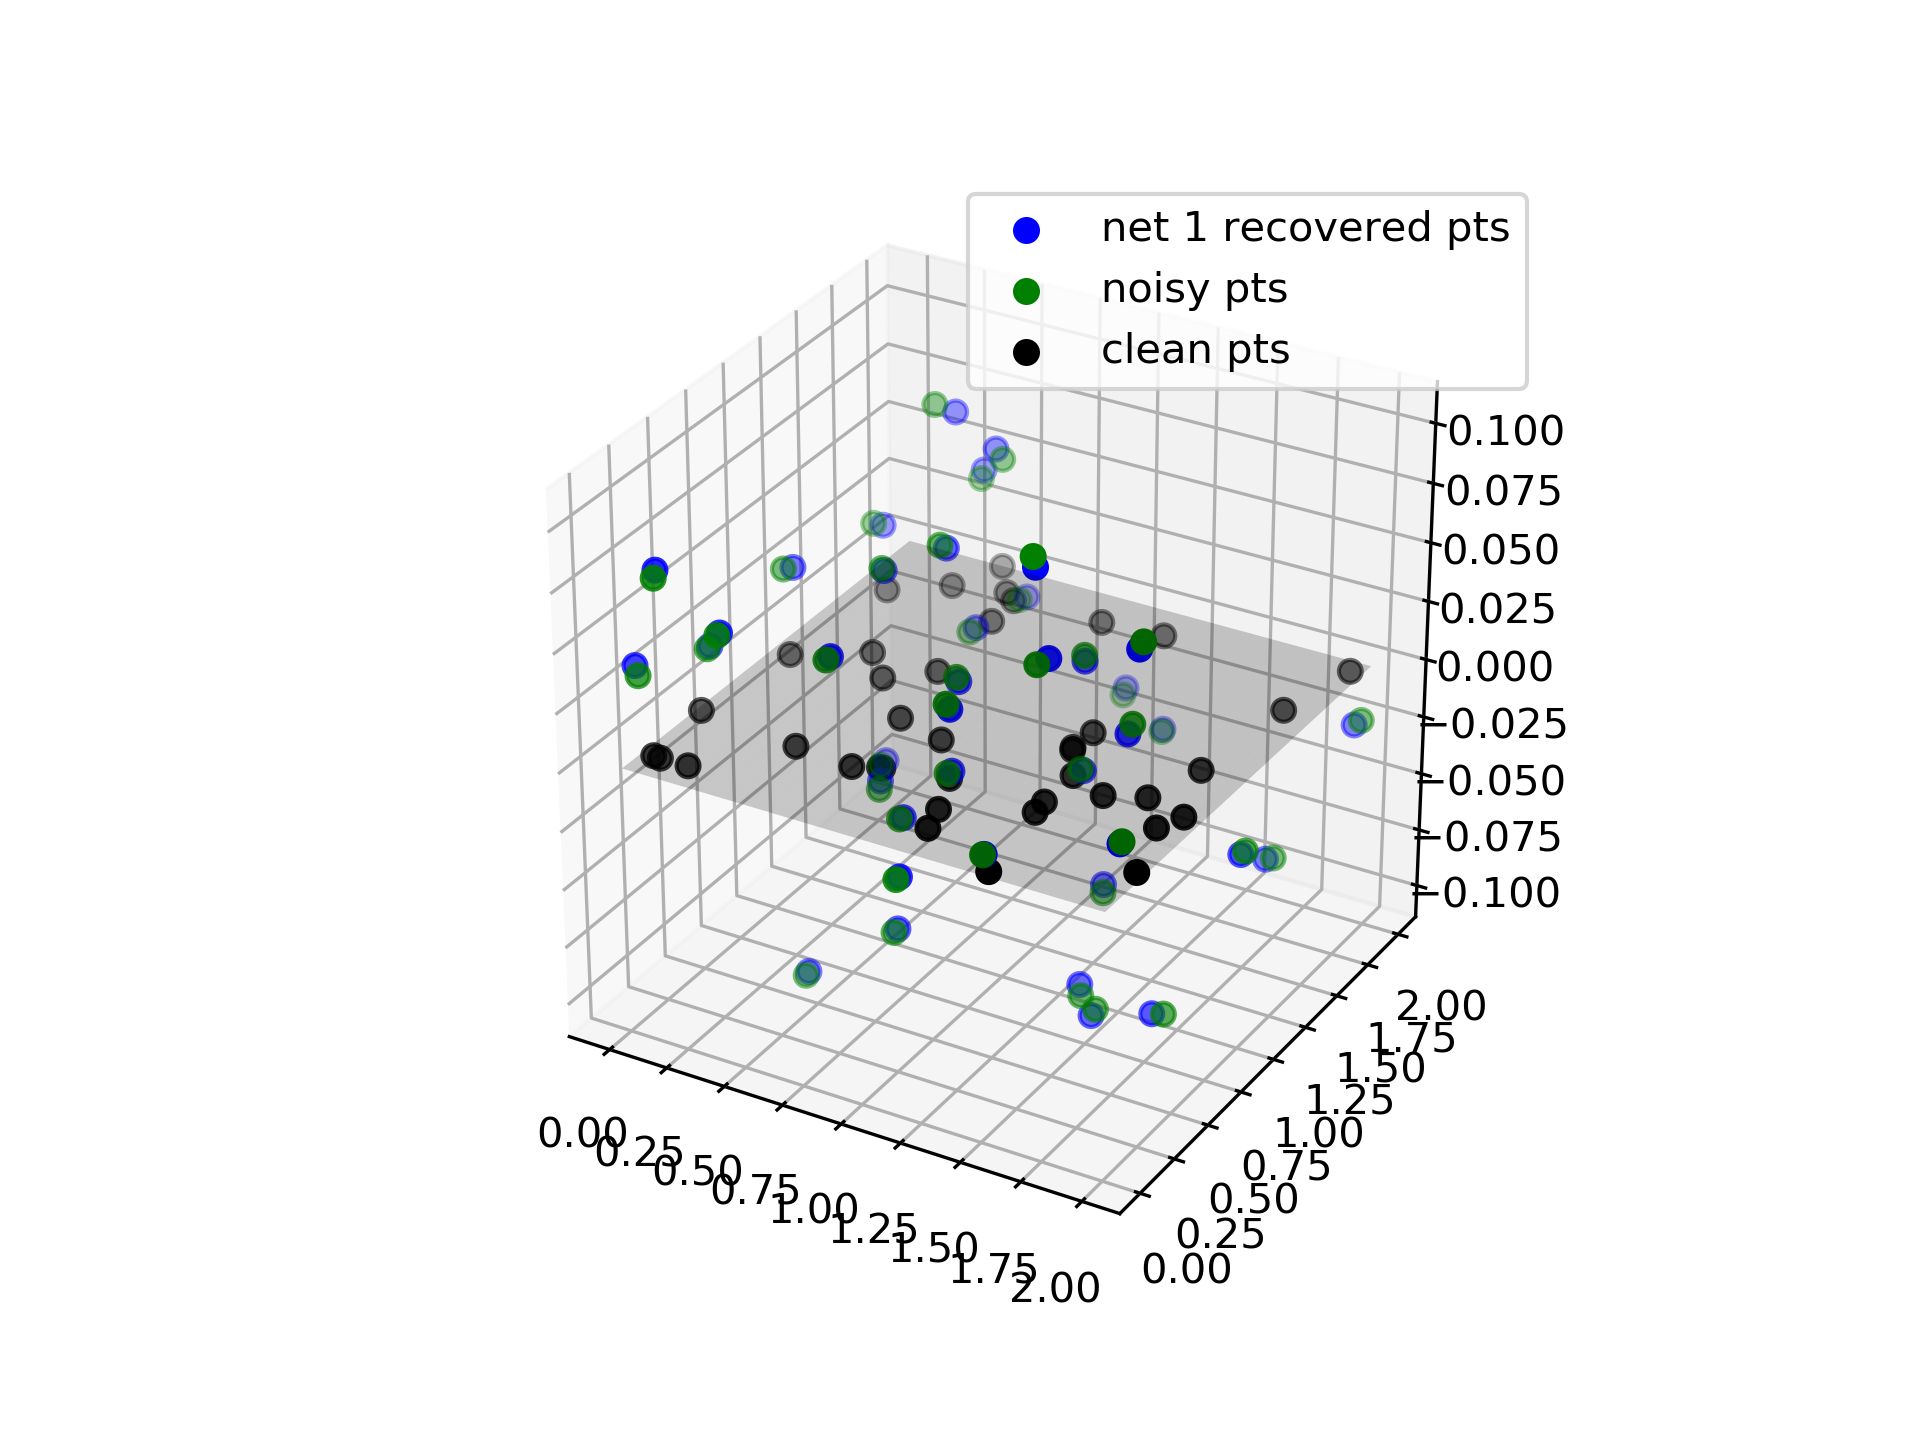

In [59]:
Yhat1 = model1(v1).detach().numpy()
Yhat2 = model2(v2).detach().numpy()
fig, ax = plt.subplots(1, 1, subplot_kw={'projection':'3d', 'aspect':'equal'})
ax.scatter(Yhat1[:100,0], Yhat1[:100,1], Yhat1[:100,2], s=30, c='b', zorder=10, label = 'net 1 recovered pts')
ax.scatter(Y[:100,0], Y[:100,1], Y[:100,2], s = 30, c = 'g', zorder = 10, label = 'noisy pts')
ax.scatter(X[:100,0], X[:100,1], X[:100,2], s = 30, c = 'k', zorder = 10, label = 'clean pts')
ax.plot_surface(planeX, planeY, planeZ, rstride=1, cstride=1, alpha=0.2,
                cmap='bone', edgecolor='none')
ax.legend()

<IPython.core.display.Javascript object>


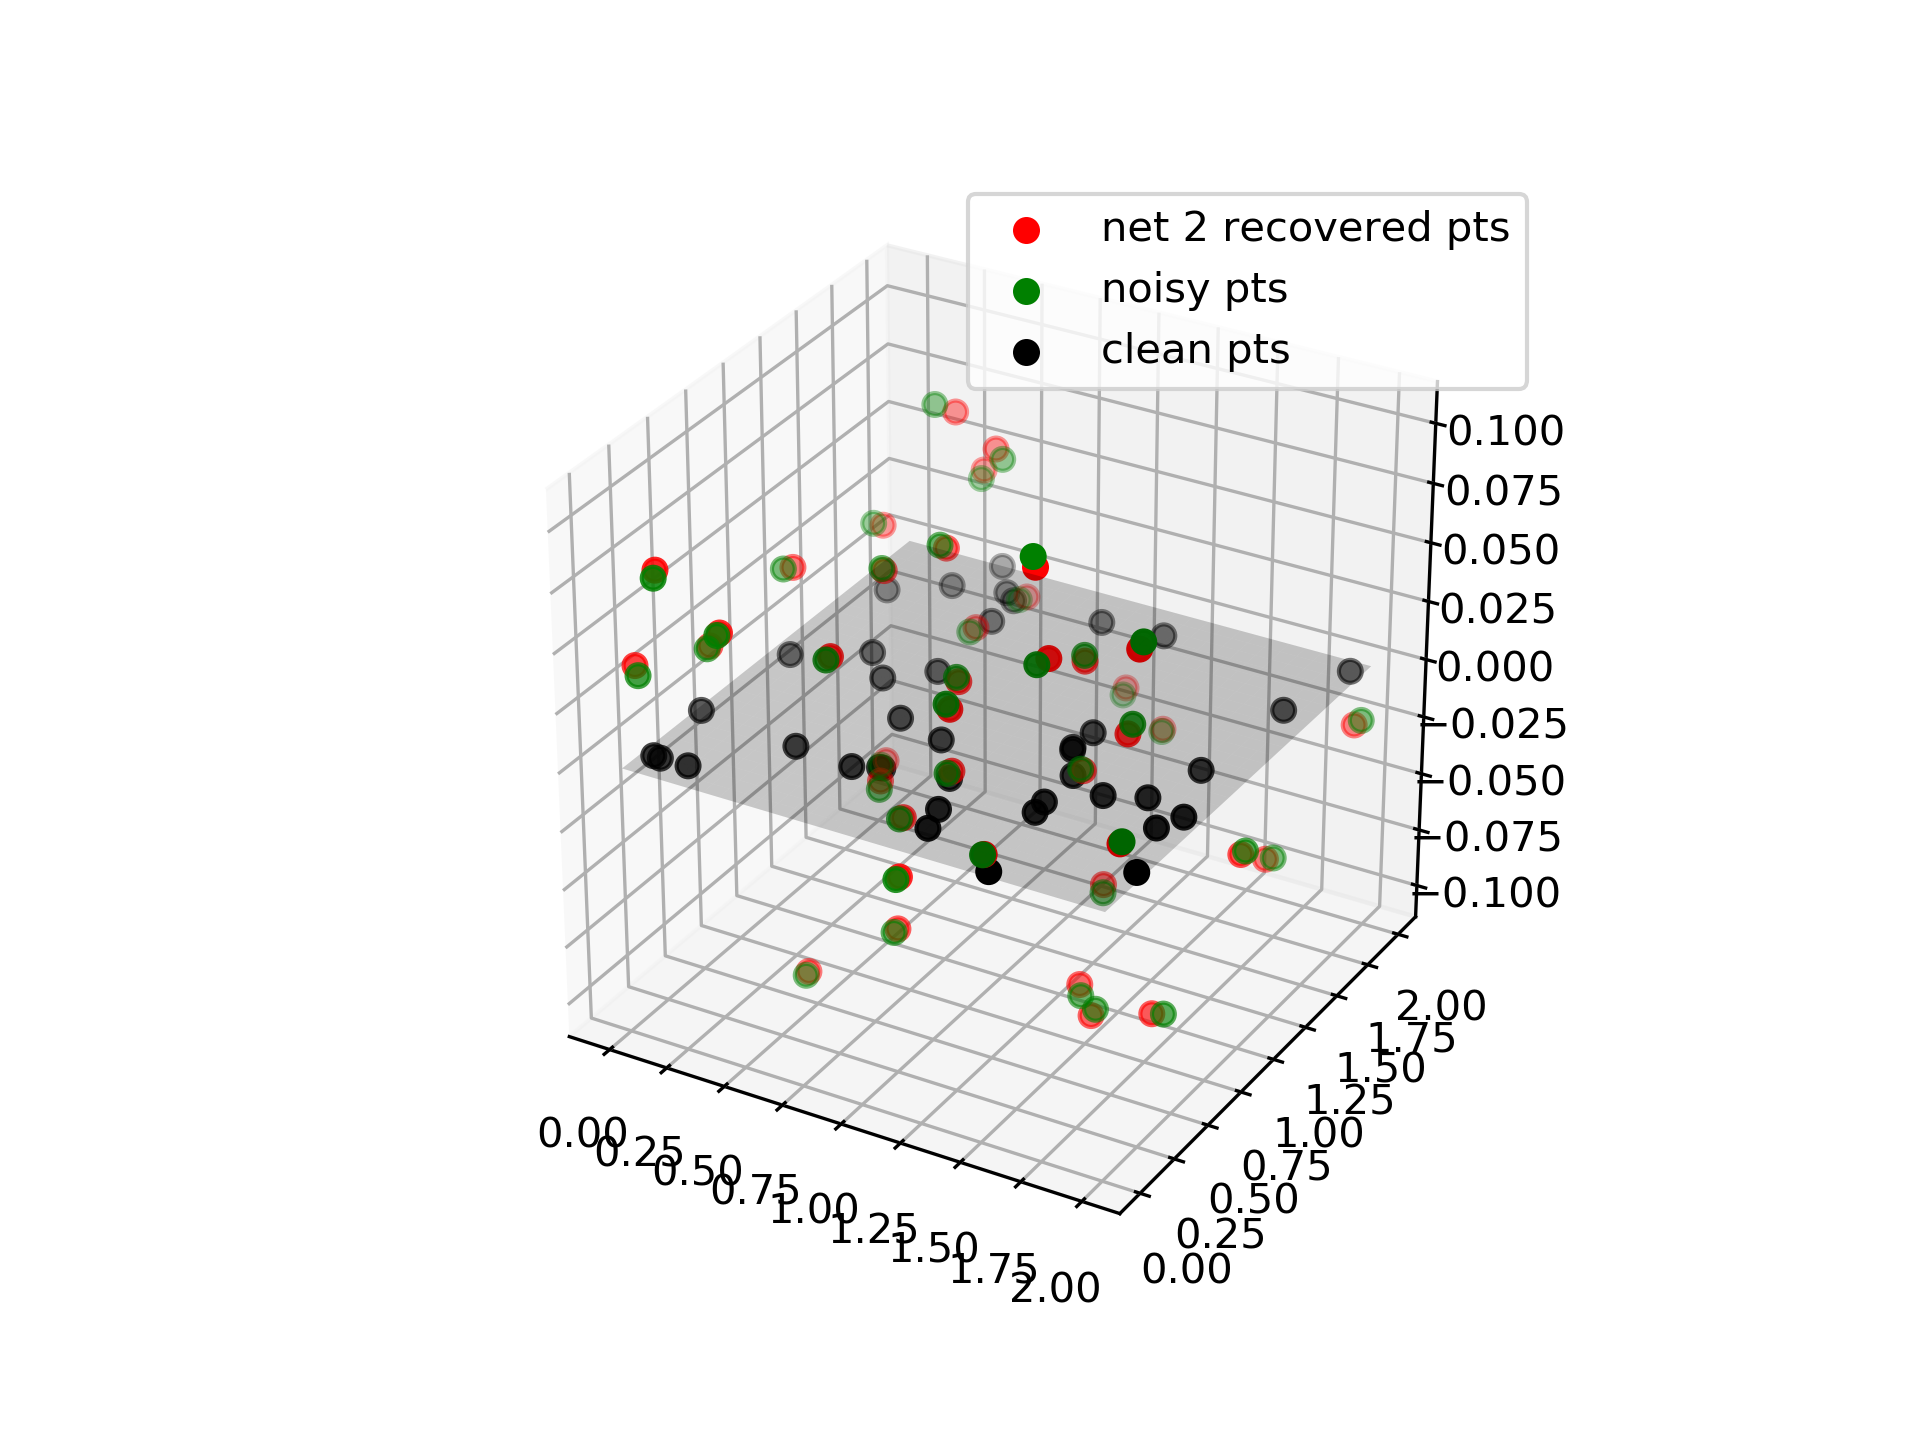

In [60]:
fig, ax = plt.subplots(1, 1, subplot_kw={'projection':'3d', 'aspect':'equal'})
ax.scatter(Yhat2[:100,0], Yhat2[:100,1], Yhat2[:100,2], s=30, c='r', zorder=10, label = 'net 2 recovered pts')
ax.scatter(Y[:100,0], Y[:100,1], Y[:100,2], s = 30, c = 'g', zorder = 10, label = 'noisy pts')
ax.scatter(X[:100,0], X[:100,1], X[:100,2], s = 30, c = 'k', zorder = 10, label = 'clean pts')
ax.plot_surface(planeX, planeY, planeZ, rstride=1, cstride=1, alpha=0.2,
                cmap='bone', edgecolor='none')
ax.legend()